In [52]:
%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 4)

from util import util
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance


data_folder = os.path.join('..', 'data')
file_name = "DataForModel"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Logistic Regression

Another method to create predictions is to use Logistic Regression. We will use Multi-class Logistic Regression to predict the three possible outcomes of Home Win, Draw, or Away Win.

### Load Data

In [53]:
data = util.load_data(data_folder, file_name)
data = data[data['Div'] == 'E0']
data.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,Season,ELO diff,Home_prob_ELO,Draw_prob_ELO,...,Diff_shots_on_target_attempted,Diff_shots_on_target_allowed,Diff_shots_attempted,Diff_shots_allowed,Diff_corners_awarded,Diff_corners_conceded,Diff_fouls_commited,Diff_fouls_suffered,Diff_yellow_cards,Diff_red_cards
0,E0,2005-09-17,Aston Villa,Tottenham,1.0,1.0,0506,-25.173204,0.412832,0.245673,...,-9,10,-14,16,20,18,-13,9,-6,0
1,E0,2005-09-17,Portsmouth,Birmingham,1.0,1.0,0506,6.045620,0.468846,0.222236,...,4,-2,4,-4,0,13,6,17,1,0
2,E0,2005-09-17,Sunderland,West Brom,1.0,1.0,0506,-32.751187,0.399092,0.251422,...,9,-1,-4,8,5,0,-1,-21,-3,1
3,E0,2005-09-18,Blackburn,Newcastle,0.0,3.0,0506,34.014412,0.517707,0.201792,...,1,-13,7,-15,5,-14,0,-2,1,0
4,E0,2005-09-18,Man City,Bolton,0.0,1.0,0506,33.333649,0.516538,0.202282,...,3,3,-8,18,-4,2,-6,-17,3,0


### Define features and target

In [54]:
x_cols = ['ELO diff', 'Home_prob_ELO', 'Draw_prob_ELO', 'Away_prob_ELO',
       'Diff_goals_scored', 'Diff_goals_conceded', 'Diff_goal_diff',
       'Diff_points', 'Diff_change_in_ELO', 'Diff_opposition_mean_ELO',
       'Diff_shots_on_target_attempted', 'Diff_shots_on_target_allowed',
       'Diff_shots_attempted', 'Diff_shots_allowed', 'Diff_corners_awarded',
       'Diff_corners_conceded', 'Diff_fouls_commited', 'Diff_fouls_suffered',
       'Diff_yellow_cards', 'Diff_red_cards']
data["Outcome"] = data.apply(
    lambda row: (
        1 if row["FTHG"] > row["FTAG"] else (0 if row["FTHG"] == row["FTAG"] else -1)
    ),
    axis=1,
)
y_cols = ['Outcome']
X = data[x_cols]
y = data[y_cols]

### Set up training and test sets

We scale the data with a StandardScaler

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Training a model

Now, we train a Logistic Regression model on the training data. We want to see how well it performs in different evaluation metrics.

/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/heiken/Desktop/NTNU/4

Training accuracy: 0.5429656274980016
Test accuracy: 0.5851318944844125
AUC for class -1 (Away Win): 0.75
AUC for class 0 (Draw): 0.60
AUC for class 1 (Home Win): 0.75
Classification Report:
               precision    recall  f1-score   support

          -1       0.53      0.58      0.55       368
           0       0.00      0.00      0.00       268
           1       0.61      0.84      0.71       615

    accuracy                           0.59      1251
   macro avg       0.38      0.47      0.42      1251
weighted avg       0.46      0.59      0.51      1251



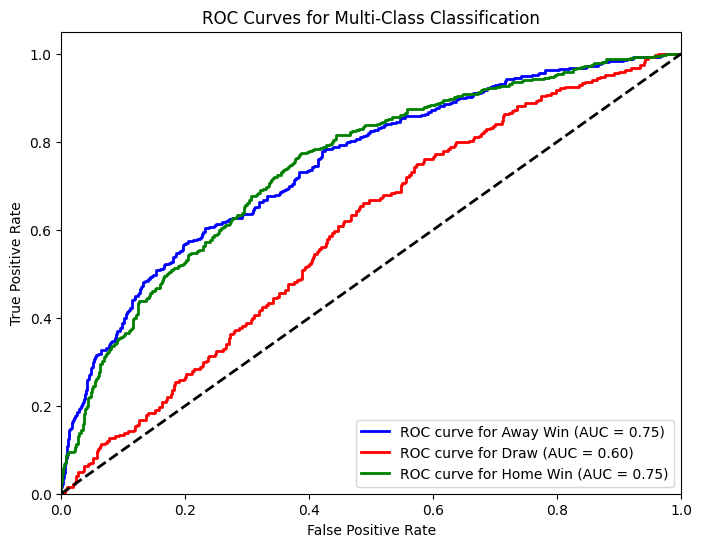

In [56]:
model = LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga')
model.fit(X_train, y_train)

class_names=["Away Win", "Draw", "Home Win"]

# Evaluate the model
print("Training accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

# Compute AUC per class
y_pred_prob = model.predict_proba(X_test)
for i, class_label in enumerate(model.classes_):
    auc_score = roc_auc_score(y_test == class_label, y_pred_prob[:, i])
    print(f"AUC for class {class_label} ({class_names[i]}): {auc_score:.2f}")

# Make predictions
y_pred = model.predict(X_test)


# Generate classification report
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

util.plot_multi_class_roc(
    y_test, y_pred_prob, classes=[-1, 0, 1], class_names=class_names
)

The model gives a fair AUC score of 0.75 for Home and Away wins, but has a harder time predicting draws. We see from the classification report that the model in fact totally misses the draws. But the high score for the Home and Away wins is a good sign, which we can build upon. If we allow the model to only predict matches where there is a higher chance of either a Home or Away win, we might get a better model.

As an example, lets add the requirement that the ELO difference, signifying the long term strength difference, is greater than 100 in either direction. This will remove matches where the teams are very close in strength, and the model has a harder time predicting the outcome. The dataset becomes smaller, but the model might become better performing.

In [57]:
data_trimmed = data[(data['ELO diff'] > 100) | (data['ELO diff'] < -100)]
data_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3260 entries, 6 to 32527
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Div                             3260 non-null   object        
 1   Date                            3260 non-null   datetime64[ns]
 2   HomeTeam                        3260 non-null   object        
 3   AwayTeam                        3260 non-null   object        
 4   FTHG                            3260 non-null   float64       
 5   FTAG                            3260 non-null   float64       
 6   Season                          3260 non-null   object        
 7   ELO diff                        3260 non-null   float64       
 8   Home_prob_ELO                   3260 non-null   float64       
 9   Draw_prob_ELO                   3260 non-null   float64       
 10  Away_prob_ELO                   3260 non-null   float64       
 11  Diff_goa

We see the rows are almost cut in half, but if the model is better at predicting for this subset, it might be worth it. Let's train a model on this dataset.

Training accuracy: 0.6196319018404908
Test accuracy: 0.6365030674846626
AUC for class -1 (Away Win): 0.79
AUC for class 0 (Draw): 0.54
AUC for class 1 (Home Win): 0.78
Classification Report:
               precision    recall  f1-score   support

          -1       0.56      0.78      0.65       215
           0       0.29      0.02      0.03       114
           1       0.71      0.76      0.74       323

    accuracy                           0.64       652
   macro avg       0.52      0.52      0.47       652
weighted avg       0.59      0.64      0.58       652



/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


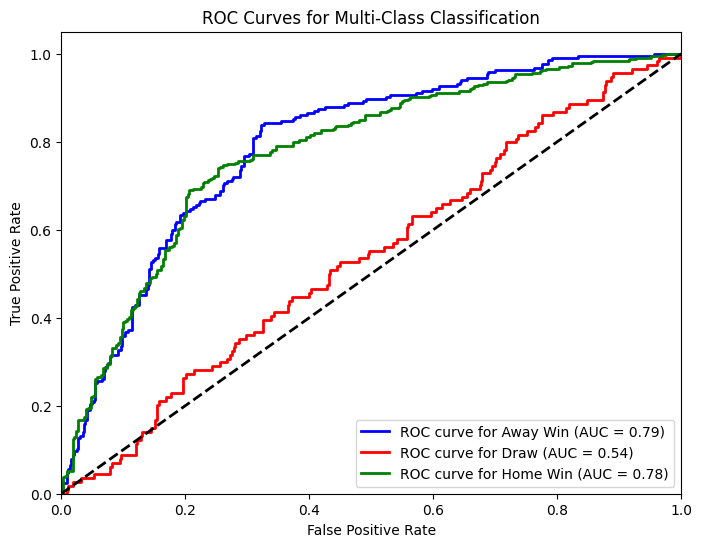

In [58]:
X = data_trimmed[x_cols]
y = data_trimmed[y_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga')
model.fit(X_train, y_train)

class_names=["Away Win", "Draw", "Home Win"]

# Evaluate the model
print("Training accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

# Compute AUC per class
y_pred_prob = model.predict_proba(X_test)
for i, class_label in enumerate(model.classes_):
    auc_score = roc_auc_score(y_test == class_label, y_pred_prob[:, i])
    print(f"AUC for class {class_label} ({class_names[i]}): {auc_score:.2f}")

# Make predictions
y_pred = model.predict(X_test)


# Generate classification report
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

util.plot_multi_class_roc(
    y_test, y_pred_prob, classes=[-1, 0, 1], class_names=class_names
)

From this, we see that both the AUC for Home and Away wins have increased, and the total accuracy for the test set has increased quite a lot. The recall from the whole dataset would be pretty bad, but for this specific subset, the performance is quite good. There is possibly a correlation between how trimmed the dataset is and the performance of the model analyzing it.

### Setting a threshold

Finding a good threshold for what matches to cut involves finding a compromise between improving performance and reducing the eligible matches. Let's look at how moving the ELO threshold influences these metrics.

First, define the function to get different metrics at a particular threshold.

In [59]:
model = LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga')


def evaluate_model(data, model, scaler: StandardScaler, threshold=0, column='ELO diff'):
	use_data = data.copy()
	use_data = use_data[(data[column] > threshold) | (data[column] < -threshold)]
	X, y = use_data[x_cols], use_data[y_cols]
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
	X_train = scaler.fit_transform(X_train)
	X_test = scaler.transform(X_test)
	model.fit(X_train, y_train)

	training_accuracy = model.score(X_train, y_train)
	test_accuracy = model.score(X_test, y_test)
	
	AUCs = []
	y_pred_prob = model.predict_proba(X_test)
	for i, class_label in enumerate(model.classes_):
		auc_score = roc_auc_score(y_test == class_label, y_pred_prob[:, i])
		AUCs.append(auc_score)
		
	return training_accuracy, test_accuracy, AUCs[0], AUCs[1], AUCs[2], len(use_data)/len(data)

Now, lets look at how the metrics evolve as we trim more and more.

/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/heiken/Desktop/NTNU/4. klasse/Artificial Intelligence in Industry/Match Predictor/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/heiken/Desktop/NTNU/4

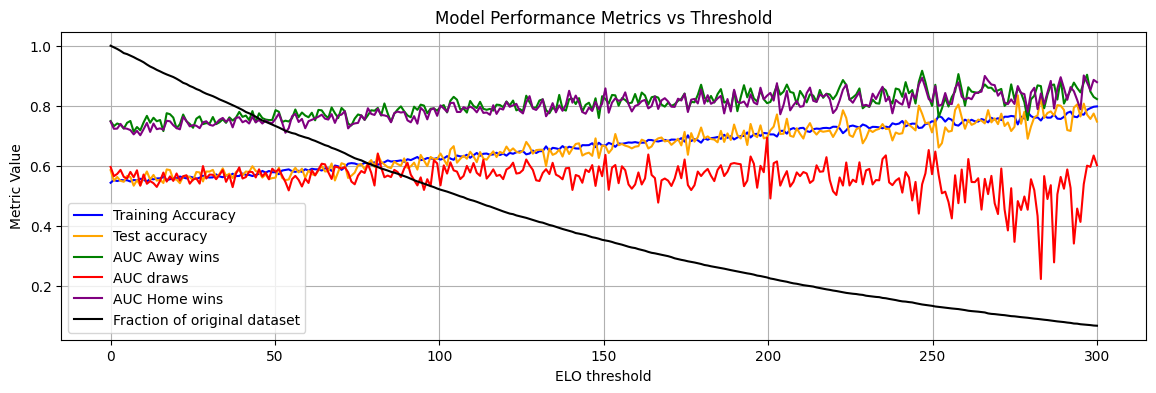

In [60]:
threshold_range = np.linspace(0, 300, 300)

results = {
    "threshold": [],
    "training_accuracy": [],
    "test_accuracy": [],
    "AUC_0": [],
    "AUC_1": [],
    "AUC_2": [],
    "fraction": []
}

for threshold in threshold_range:
    training_accuracy, test_accuracy, AUC_0, AUC_1, AUC_2, fraction = evaluate_model(data, model, scaler, threshold)
    results["threshold"].append(threshold)
    results["training_accuracy"].append(training_accuracy)
    results["test_accuracy"].append(test_accuracy)
    results["AUC_0"].append(AUC_0)
    results["AUC_1"].append(AUC_1)
    results["AUC_2"].append(AUC_2)
    results["fraction"].append(fraction)
    

# Convert results to a DataFrame for easier plotting
results_df = pd.DataFrame(results)

# Plot each metric against the threshold range
util.plot_multiple_lines(results_df, x_col='threshold', line_cols=['training_accuracy', 'test_accuracy', 'AUC_0', 'AUC_1', 'AUC_2', 'fraction'], line_labels=['Training Accuracy', 'Test accuracy', 'AUC Away wins', 'AUC draws', 'AUC Home wins', 'Fraction of original dataset'], figsize=figsize, x_label='ELO threshold')

We can see from the graph that as the dataset is more selective, the performance increases. There is therefore a tradeoff between performance and size of dataset due to requirements filtering out close matches.